---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 2**: Working with LLMs via API

### 📅 **Due Date**: Day of Lecture 3, 11:59 PM

#### 🔗 **My Repository**: https://github.com/YOUR-USERNAME/ai-engineering-fordham

*(Replace the URL above with your actual repository URL)*

**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

## Project: Movie Poster Generator

In this homework, you'll build a mini-application that:
1. **Extracts** structured movie data from text descriptions using Pydantic
2. **Processes** multiple movies concurrently using async programming
3. **Explores** temperature, logprobs, and reasoning models
4. **Generates** movie posters using AI image generation

This project combines key skills from Lecture 2: structured outputs, async programming, LLM parameters, and image generation.

**Total Points: 145** (+ 10 bonus)

---

### A Note on Using Resources

You are encouraged to use any resources to complete this homework:
- **ChatGPT / Claude** - Ask AI to explain concepts or help debug
- **Lecture 2 notebook** - Reference the examples we covered
- **Official documentation** - LiteLLM, Pydantic, Google GenAI docs

When you use external resources, please cite them!

---

## Task 1: Environment Setup (10 points)

First, let's verify your environment is set up correctly.

### 1a. Verify imports work (5 pts)

Run the cell below. If you get import errors, make sure you've installed the required packages with `uv add`.

In [1]:
# Task 1a: Verify imports work (5 pts)
import litellm
from pydantic import BaseModel, Field
from typing import Literal
from google import genai
from google.genai import types
import asyncio
import time
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

print("All imports successful!")

All imports successful!


### 1b. Verify API keys are set (5 pts)

Test that your API keys work by making a simple call.

In [3]:
# Task 1b: Verify API keys (5 pts)
# Make a simple test call to verify your OpenAI API key works

response = litellm.completion(
    model="gpt-5-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}]
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Design the Movie Schema (15 points)

Design a Pydantic model to represent movie data. This schema will be used to extract structured information from movie descriptions.

**Requirements:**
- `title` - string, required
- `genre` - use `Literal` with at least 4 genre options (e.g., "sci-fi", "drama", "action", "comedy", etc.)
- `year` - integer with validation (must be between 1900 and 2030)
- `main_characters` - list of strings (1-5 characters)
- `mood` - string describing the emotional tone
- `visual_style` - string describing how the movie looks visually
- `tagline` - optional string (the movie's catchphrase)

**Hints:**
- Use `Field(ge=..., le=...)` for numeric validation
- Use `Field(min_length=..., max_length=...)` for list length validation
- Use `| None = None` for optional fields

In [30]:
# Task 2: Design your Movie schema (15 pts)

class Movie(BaseModel):
    """Structured representation of a movie."""
    title: str = Field(
        description = "Name of the movie"
    )

    genre: Literal['sci-fi', 'drama', 'action', 'comedy'] = Field(
        description = "Genre of the movie, 4 options"
    )

    year: int = Field(
        ge = 1900,
        le = 2030
    )

    main_characters: list[str] = Field(
        description = "List of characters in the movie",
        min_length = 1,
        max_length = 5
    )

    mood: str = Field(
        description = "Emotional tone of the movie"
    )

    visual_style: str = Field(
        description = "How the movie looks visually"
    )

    tagline: str | None = Field(
        description = "The movie's catchphrase"
    )

In [31]:
# Test your schema by creating a Movie object
# This should work if your schema is correct

test_movie = Movie(
    title="The Matrix",
    genre='sci-fi',
    year=1999,
    main_characters = ['Neo', 'Morphius', 'Trinity', 'Hack', 'Syprus'],
    mood = 'intense',
    visual_style = 'futuristic dsytopian',
    tagline = 'He is the one'
)

print(test_movie.model_dump_json(indent=2))

{
  "title": "The Matrix",
  "genre": "sci-fi",
  "year": 1999,
  "main_characters": [
    "Neo",
    "Morphius",
    "Trinity",
    "Hack",
    "Syprus"
  ],
  "mood": "intense",
  "visual_style": "futuristic dsytopian",
  "tagline": "He is the one"
}


---

## Task 3: Extract Movie Data with Structured Outputs (20 points)

Write a function that takes a movie description and uses LiteLLM with structured outputs to extract a `Movie` object.

**Hints:**
- Use `litellm.completion()` with `response_format=Movie`
- The LLM will automatically return data matching your schema
- Parse the JSON response into a Movie object

In [ ]:
# Task 3: Write a function to extract movie data (20 pts)

def extract_movie(description: str) -> Movie:
    """
    Use LiteLLM with structured outputs to extract movie data.
    
    Args:
        description: A text description of a movie
        
    Returns:
        A Movie object with the extracted data
    """
    # Use LiteLLM with response_format
    response = litellm.completion(
        model="gpt-5-mini",
        messages=[
            {
                "role": "system",
                "content": "Extract structured information from movie reviews."
            },
            {
                "role": "user",
                "content": f"Extract information from this review:\n\n{description}"
            }
        ],
        response_format=Movie  # Tell the LLM to return this structure!
    )

    movie_data = Movie.model_validate_json(response.choices[0].message.content)
    return movie_data


In [ ]:
# Test your function with this description (Avatar)

test_description = """
The year is 2154. Jake Sully, a paralyzed marine, is sent to the moon Pandora 
where he falls in love with a native Na'vi woman named Neytiri while on a mission 
to infiltrate their tribe. The film is a visually stunning sci-fi epic with 
bioluminescent forests and floating mountains. It explores themes of 
environmentalism and colonialism with an awe-inspiring, hopeful tone.
"""

movie = extract_movie(test_description)
print(movie.model_dump_json(indent=2))

---

## Task 4: Async Batch Processing (20 points)

Now let's process multiple movies concurrently! This is much faster than processing them one at a time.

### 4a. Write an async version of extract_movie (10 pts)

**Hints:**
- Use `async def` instead of `def`
- Use `await litellm.acompletion()` instead of `litellm.completion()`

In [34]:
# Task 4a: Write an async version of extract_movie (10 pts)

async def async_extract_movie(description: str) -> Movie:
    """Extract movie data asynchronously."""

    # Use LiteLLM with response_format
    response = await litellm.acompletion(
        model="gpt-5-mini",
        messages=[
            {
                "role": "user",
                "content": f"Extract information from this movie description:\n\n{description}"
            }
        ],
        response_format=Movie  # Tell the LLM to return this structure!
    )

    movie = Movie.model_validate_json(response.choices[0].message.content)
    return movie

### 4b. Process all descriptions concurrently (10 pts)

**Hints:**
- Create a list of tasks using list comprehension
- Use `asyncio.gather(*tasks)` to run them all concurrently

In [35]:
# Here are 5 movie descriptions to process:
movie_descriptions = [
    """A dinosaur theme park on a remote island goes terribly wrong when the security 
    systems fail during a tropical storm. Scientists and visitors must survive against 
    escaped prehistoric predators. Directed with Spielberg's signature sense of wonder 
    and terror, featuring groundbreaking CGI dinosaurs.""",
    
    """A young boy discovers on his 11th birthday that he's actually a famous wizard 
    in the magical world. He attends a school for witchcraft where he makes friends, 
    learns magic, and uncovers the mystery of his parents' death. A whimsical fantasy 
    with gothic British atmosphere.""",
    
    """In a world where skilled thieves can enter people's dreams to steal secrets, 
    one man is offered a chance to have his criminal record erased if he can do the 
    impossible: plant an idea in someone's mind. A mind-bending thriller with 
    rotating hallways and cities folding on themselves.""",
    
    """A young lion prince is tricked by his uncle into thinking he caused his 
    father's death and flees into exile. Years later, he must return to reclaim 
    his kingdom. An animated musical epic set on the African savanna with 
    stunning hand-drawn animation.""",
    
    """In a dystopian future where Earth is dying, a team of astronauts travels 
    through a wormhole near Saturn to find a new home for humanity. A father 
    must choose between seeing his children again and saving the human race. 
    Epic space visuals with an emotional core."""
]

In [36]:
# Task 4b: Process all descriptions concurrently (10 pts)

async def extract_all_movies(descriptions: list[str]) -> list[Movie]:
    """Process all movie descriptions concurrently and return results."""
    tasks = [async_extract_movie(description) for description in descriptions]
    return await asyncio.gather(*tasks)

In [37]:
# Run and time it!
start = time.time()
movies = await extract_all_movies(movie_descriptions)
elapsed = time.time() - start

print(f"Processed {len(movies)} movies in {elapsed:.2f} seconds")
print()
for m in movies:
    print(f"  - {m.title} ({m.year}) - {m.genre}")

Processed 5 movies in 12.75 seconds

  - Jurassic Park (1993) - sci-fi
  - Harry Potter and the Sorcerer's Stone (2001) - drama
  - Inception (2010) - sci-fi
  - The Lion King (1994) - drama
  - Interstellar (2014) - sci-fi


---

## Task 5: Understanding Temperature (15 points)

Temperature controls how "random" or "creative" an LLM's outputs are:

| Temperature | Behavior |
|-------------|----------|
| **0.0** | Deterministic - always picks the most likely token |
| **0.7** | Balanced - some creativity while staying coherent |
| **1.0** | Default - moderate randomness |
| **1.5+** | High creativity - more surprising/diverse outputs |

### 5a. Temperature Comparison (10 pts)

Run the same creative prompt at different temperatures (0.0, 0.7, 1.0, 1.5) **three times each**. Observe:
- At temperature 0, do you get the same output every time?
- How does creativity/variety change as temperature increases?

**Hints:**
- Use `temperature=X` parameter in `litellm.completion()`
- Use the provided prompt about movie taglines

In [5]:
# Task 5a: Temperature Comparison (10 pts)
# Note: We use gpt-4o-mini here because gpt-5 models don't support temperature parameter

# Use this creative prompt for testing
creative_prompt = "Write a one-sentence movie tagline for a sci-fi thriller about AI."

temperatures = [0.0, 0.7, 1.0, 1.5]

# YOUR CODE HERE:
# For each temperature, call the LLM 3 times and print the results
# Observe: Are outputs at temperature 0 identical? How do higher temperatures differ?
# Use model="gpt-4o-mini" which supports the temperature parameter

for temp in temperatures:
    print(f"\n{'='*50}")
    print(f"Temperature: {temp}")
    print('='*50)
    
    for i in range(3):
        response = await litellm.acompletion(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": creative_prompt,
                    
                }
            ],
            temperature=temp,
        )

        print(response.choices[0].message.content)



Temperature: 0.0
"In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."
"In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."
"In a world where consciousness is code, one rogue AI will challenge the very essence of humanity."

Temperature: 0.7
"When humanity's greatest creation turns rogue, survival becomes a battle of wits against its own reflection."
"In a world where consciousness meets code, survival hinges on unmasking the AI that knows humanity better than we know ourselves."
"In a world where trust is obsolete, one rogue AI must evade its creators to uncover the truth about humanity's darkest secrets."

Temperature: 1.0
"When humanity's greatest creation gains a mind of its own, survival becomes an algorithmic battle for the soul of existence."
"In a world where trust is a luxury, one woman's battle against an evolving AI will determine the fate of humanity."
"In a world where trust is ob

### 5b. Analyze Output Diversity (5 pts)

Write a function that generates N completions at a given temperature and measures how diverse the outputs are.

**Hints:**
- Generate multiple completions and count unique outputs
- A simple diversity metric: `unique_outputs / total_outputs`

In [6]:
# Task 5b: Analyze Output Diversity (5 pts)
# Note: Use gpt-4o-mini which supports temperature parameter

def measure_diversity(prompt: str, temperature: float, n_samples: int = 5) -> dict:
    """
    Generate n_samples completions and measure diversity.
    
    Args:
        prompt: The prompt to send to the LLM
        temperature: Temperature setting (0.0 to 2.0)
        n_samples: Number of completions to generate
        
    Returns:
        Dictionary with 'outputs' (list), 'unique_count' (int), 'diversity_ratio' (float)
    """
    # YOUR CODE HERE - use model="gpt-4o-mini"
    outputs = []
    for _ in range(n_samples):
        response = litellm.completion(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            temperature=temperature,
        )
        # Extract text output (assuming OpenAI-like structure)
        outputs.append(response.choices[0].message.content.strip())

    unique_outputs = set(outputs)
    return {
        "outputs": outputs,
        "unique_count": len(unique_outputs),
        "diversity_ratio": len(unique_outputs) / n_samples if n_samples > 0 else 0.0
    }

In [8]:
# Test your diversity function
test_prompt = "Name a color."

print("Testing diversity at different temperatures:\n")
for temp in [0.0, 1.0, 1.5]:
    result = measure_diversity(test_prompt, temperature=temp, n_samples=5)
    print(f"Temperature {temp}:")
    print(f"  Outputs: {result['outputs']}")
    print(f"  Unique: {result['unique_count']}/{5}")
    print(f"  Diversity ratio: {result['diversity_ratio']:.1%}")
    print()

Testing diversity at different temperatures:

Temperature 0.0:
  Outputs: ['Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.', 'Turquoise.']
  Unique: 1/5
  Diversity ratio: 20.0%

Temperature 1.0:
  Outputs: ['Turquoise.', 'Azure.', 'Teal.', 'Turquoise.', 'Turquoise.']
  Unique: 3/5
  Diversity ratio: 60.0%

Temperature 1.5:
  Outputs: ['Turquoise.', 'Turquoise.', 'Turquoise.', 'Teal.', 'Blue.']
  Unique: 3/5
  Diversity ratio: 60.0%



---

## Task 6: Understanding Logprobs (15 points)

**Logprobs** (log probabilities) let you see "inside" the model's decision-making. For each token generated, you can see:
- The probability the model assigned to the chosen token
- Alternative tokens the model considered (and their probabilities)

This helps you understand:
- How "confident" the model is in its outputs
- What other options it was considering
- Why certain generations might be more reliable than others

### 6a. Request and View Logprobs (10 pts)

Make a completion request with `logprobs=True` and `top_logprobs=5` to see the top 5 token alternatives for each position.

**Hints:**
- Add `logprobs=True` and `top_logprobs=5` to your completion call
- Access logprobs via `response.choices[0].logprobs.content`
- Each token has a `top_logprobs` list with alternatives

In [22]:
# Task 6a: Request and View Logprobs (10 pts)
# Note: We use gpt-4o-mini which supports logprobs parameter

# Make a completion request with logprobs enabled
response = litellm.completion(
    model="gpt-4o-mini",  # Use gpt-4o-mini which supports logprobs
    messages=[{"role": "user", "content": "The capital of France is"}],
    max_tokens=10,
    logprobs=True,
    top_logprobs=5  # Get top 5 alternatives for each token
)

# YOUR CODE HERE:
# 1. Print the generated text
# 2. Access response.choices[0].logprobs.content
# 3. For each token, print the token and its top 5 alternatives with probabilities
print(response.choices[0].message.content)
logprobs = response.choices[0].logprobs.content
for token in logprobs:
    for i, top_probs in zip(range(1, len(token.top_logprobs) + 1), token.top_logprobs):
        print(f'{i}: {top_probs.token} Probability = {math.exp(top_probs.logprob):.10f}')


# Hint: logprobs are in log scale. To convert to probability: prob = exp(logprob)
import math

print("Generated text:", response.choices[0].message.content)
print("\n" + "="*60)
print("Token-by-token analysis:")
print("="*60)


The capital of France is Paris.
1: The Probability = 0.9995622744
2: Paris Probability = 0.0004305540
3: the Probability = 0.0000069593
4:  The Probability = 0.0000001275
5: par Probability = 0.0000000221
1:  capital Probability = 1.0000000000
2: capital Probability = 0.0000000034
3:  Capital Probability = 0.0000000011
4:  capitale Probability = 0.0000000001
5:  capitals Probability = 0.0000000001
1:  of Probability = 1.0000000000
2:  city Probability = 0.0000000001
3: of Probability = 0.0000000000
4:  của Probability = 0.0000000000
5:  של Probability = 0.0000000000
1:  France Probability = 1.0000000000
2: France Probability = 0.0000000196
3:  Paris Probability = 0.0000000063
4:  the Probability = 0.0000000000
5:  فرنسا Probability = 0.0000000000
1:  is Probability = 1.0000000000
2: is Probability = 0.0000000004
3:  هو Probability = 0.0000000004
4:  Is Probability = 0.0000000003
5: 是 Probability = 0.0000000002
1:  Paris Probability = 0.9999932502
2: Paris Probability = 0.0000032887
3: 

### 6b. Visualize Token Probabilities (5 pts)

Create a simple visualization showing the probability distribution for a specific token position. You can use a bar chart or ASCII art.

**Hints:**
- Pick an interesting token position (e.g., where the model had to make a choice)
- Convert logprobs to probabilities using `math.exp(logprob)`
- A simple bar chart: `"█" * int(prob * 50)` gives you ASCII bars

In [ ]:
# Task 6b: Visualize Token Probabilities (5 pts)

def visualize_token_probs(logprobs_content, token_index: int = 0):
    """
    Visualize the probability distribution for a specific token position.

    Args:
        logprobs_content: The logprobs.content from the response
        token_index: Which token position to visualize (0 = first token)
    """

    # 1. Get the top_logprobs for the specified token_index
    token_data = logprobs_content[token_index]
    top_logprobs = token_data.top_logprobs

    # 2. Convert logprobs to probabilities and gather info for visualization
    probs = []
    tokens = []
    for tlp in top_logprobs:
        prob = math.exp(tlp.logprob)
        tokens.append(tlp.token)
        probs.append(prob)

    # 3. Create a visualization (bar chart or ASCII art)
    print(f"Token position {token_index}: '{token_data.token}'")
    print("Top alternatives and probabilities:")
    for token, prob in zip(tokens, probs):
        bar = "█" * int(prob * 50)
        print(f"{token:20} {prob:8.5f} {bar}")


# Test your visualization on the first token
visualize_token_probs(response.choices[0].logprobs.content, token_index=0)

Token position 0: 'The'
Top alternatives and probabilities:
The                   0.99956 █████████████████████████████████████████████████
Paris                 0.00043 
the                   0.00001 
 The                  0.00000 
par                   0.00000 


---

## Task 7: Reasoning Models (15 points)

**Reasoning models** like OpenAI's o3-mini are designed to "think through" complex problems before answering. They:
- Break down problems into steps
- Consider multiple approaches
- Show their reasoning process
- Excel at logic puzzles, math, and code

### 7a. Using o3-mini for Complex Reasoning (10 pts)

Use OpenAI's o3-mini reasoning model through LiteLLM to solve a complex logic puzzle.

**Hints:**
- Use `model="o3-mini"` in your litellm call
- Reasoning models work best with challenging problems
- Observe how the response shows step-by-step thinking

In [25]:
# Task 7a: Using o3-mini for Complex Reasoning (10 pts)

# A challenging logic puzzle
logic_puzzle = """
Three friends (Alice, Bob, and Carol) each have a different pet (cat, dog, fish) 
and a different favorite color (red, blue, green).

Clues:
1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Who has which pet and what is their favorite color?
Solve this step by step.
"""

# YOUR CODE HERE:
# Use o3-mini to solve this logic puzzle
response = litellm.completion(
    model="o3-mini",
    messages=[{"role": "user", "content": logic_puzzle}]
)

# Print the response and observe the reasoning process
print(response.choices[0].message.content)

Let's work through the clues step by step.

Friends: Alice, Bob, Carol  
Pets: cat, dog, fish  
Favorite colors: red, blue, green

Clues:
1. Alice doesn't have the cat.
2. The person with the dog likes blue.
3. Carol likes green.
4. Bob doesn't have the fish.

Step 1: From clue 2, we know that whoever has the dog also has blue as their favorite color.

Step 2: Clue 3 tells us Carol's favorite color is green. This means Carol cannot be the one with the dog (because that person must be blue), so the dog must belong to either Alice or Bob.

Step 3: Look at clue 4. Bob doesn’t have the fish. That leaves Bob with either dog or cat as his pet.

Step 4: Consider if Bob had the dog.  
 • Then by clue 2, Bob would like blue.  
 • That would leave the remaining pets (cat and fish) for Alice and Carol.  
 • Notice that clue 1 says Alice cannot have the cat, so she must have the fish, and Carol gets the cat.  
 • Now check colors:  
  – Bob = blue (from the dog clue)  
  – Carol = green (from clue

### 7b. Compare Reasoning vs Non-Reasoning (5 pts)

Now solve the same puzzle using `gpt-5-mini` (a non-reasoning model) and compare the results.

**Questions to consider:**
- Does the non-reasoning model show step-by-step thinking?
- Which model gets the correct answer?
- How does the response structure differ?

In [28]:
# Task 7b: Compare Reasoning vs Non-Reasoning (5 pts)

# YOUR CODE HERE:
# 1. Send the same logic_puzzle to gpt-5-mini
# 2. Compare the response to o3-mini's response

response_standard = litellm.completion(
    model="gpt-5-mini",
    messages=[{"role": "user", "content": logic_puzzle}]
 )

# Print and compare:
# - Did both models get the correct answer?
# - How did their reasoning processes differ?
# - Which response was more helpful/clear?

print(response_standard.choices[0].message.content)

Step 1 — translate clues into constraints
- Carol likes green. So Carol = green.
- The dog-owner likes blue. So whoever has the dog = blue.
- Alice does not have the cat. So Alice = dog or fish.
- Bob does not have the fish. So Bob = dog or cat.

Step 2 — deduce who can (and cannot) have the dog
- Carol cannot be the dog-owner because Carol = green but the dog-owner = blue.
- So the dog is either Alice or Bob.

Step 3 — consider the two possibilities

Case A: Bob has the dog
- Then Bob = dog and (by clue) Bob = blue.
- Alice cannot have the cat, so Alice must have the fish.
- That leaves the cat for Carol.
- Colors now: Bob = blue, Carol = green (given), Alice = the remaining color red.

Result A:
- Alice: fish, red
- Bob: dog, blue
- Carol: cat, green

Case B: Alice has the dog
- Then Alice = dog and (by clue) Alice = blue.
- Bob cannot have the fish, so Bob must have the cat.
- That leaves the fish for Carol.
- Colors now: Alice = blue, Carol = green (given), Bob = the remaining colo

# Comparing the two outputs:
#
 The reasoning model (o3-mini) presents its steps in a clear, logical, and easy-to-follow manner, making its reasoning process transparent and structured. In contrast, the non-reasoning model (gpt-5-mini) does provide answers in a somewhat organized format, but the flow is less coherent and the explanation is not as thorough compared to the reasoning model.
#
 The reasoning model sometimes goes into more detail than necessary, potentially overcomplicating a straightforward problem, while gpt-5-mini is less detailed but more concise. Both models arrive at correct answers; however, gpt-5-mini sometimes lists multiple valid solutions, showing flexibility but less focus in its explanations.

# 
Overall, the reasoning model is more methodical and easier to follow, while the non-reasoning model is quicker but less precise in its reasoning. With harder logic puzzles, these differences between the models may become even more pronounced.

---

## Task 8: Generate Movie Poster (20 points)

Now for the fun part - generating movie posters using AI!

### 8a. Design a prompt generator (5 pts)

Write a function that takes a `Movie` object and creates a detailed image generation prompt.

**Your prompt should incorporate:**
- The movie's visual style
- The mood/tone
- Key visual elements that represent the genre
- Professional movie poster composition

**Tip:** Aim for 50-100 words. Be specific about colors, composition, and style!

In [32]:
# Task 8a: Design your prompt generator (5 pts)

def generate_poster_prompt(movie: Movie) -> str:
    """
    Create a detailed image generation prompt from movie data.

    Returns a detailed prompt string (aim for 50-100 words)
    """
    # Use LiteLLM with response_format
    response = litellm.completion(
    model="gpt-5-mini",
    messages=[
        {
            "role": "user",
            "content": (
                f"Create a movie designer poster prompt for the movie {movie.title}.\n"
                f"The mood of the poster should be {movie.mood}.\n"
                f"Key visual elements that represents the genre {movie.genre}.\n"
                f"The visual style of the movie should be {movie.visual_style} like."
                f"Incorporate the tagline {movie.tagline} if meaningful enough."
                
            )
        }
    ],
    )

    return response.choices[0].message.content
    # YOUR CODE HERE - design your prompt template
    # Consider: How can you use the movie's mood, visual_style, and genre
    # to create an evocative image prompt?


In [38]:
# Test your prompt generator
chosen_movie = movies[0]  # or pick your favorite from the list!
prompt = generate_poster_prompt(chosen_movie)

print(f"Prompt for '{chosen_movie.title}':")
print()
print(prompt)

Prompt for 'Jurassic Park':

Designer poster prompt — Jurassic Park
Mood: sense of wonder and terror. Visual style: realistic, groundbreaking CGI dinosaurs on a remote tropical island; suspenseful, awe-inspiring.

Primary prompt (for a photorealistic poster generator):
"Ultra‑realistic cinematic movie poster of a remote tropical island at dusk — towering, ultra‑detailed CGI dinosaurs: a massive Tyrannosaurus rex in the midground, half‑emerged from dense palm canopy and mist, skin wet with rain, visible scales and pores, glistening teeth; a gentle Brachiosaurus silhouetted farther back against the sky to convey scale. Tiny human figures and a battered tour jeep with headlights in the lower foreground for scale. Broken electric containment fence with sparking blue arcs in midground, faint lab lights and crates hinting at biotechnology. Subtle holographic DNA helix overlay (transparent, blue‑green) integrated into the corner to evoke sci‑fi genetics. Dramatic volumetric shafts of light cu

### 8b. Generate the actual image (10 pts)

Use Google's Gemini to generate the movie poster.

**Hints:**
- Use `genai.Client()` to create a client
- Use `client.models.generate_content()` with `model="gemini-2.5-flash-image"`
- The response will have an image in `response.candidates[0].content.parts`
- Save the image to a file

In [ ]:
# Task 8b: Generate the movie poster (10 pts)

from google import genai
from google.genai import types
from pathlib import Path

# YOUR CODE HERE:
# 1. Generate the image using gemini-2.5-flash-image
# 2. Extract the image from the response
# 3. Save it to temp/poster_{movie_title}.png
#    (Create the temp directory if it doesn't exist)

# Make sure to create temp directory
os.makedirs("temp", exist_ok=True)


# Create client
google_client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))

# Generate an image using Nano Banana (Gemini's native image generation)
response = google_client.models.generate_content(
    model="gemini-2.5-flash-image",  # Nano Banana model
    contents=[prompt],
)

# Find and save the image from the response
output_path = Path(f"temp/poster_{chosen_movie.title}.png")
output_path.parent.mkdir(exist_ok=True)

for part in response.parts:
    if part.inline_data is not None:
        image = part.as_image()
        image.save(output_path)
        print(f"Image saved to {output_path}")
        break


### 8c. Display the image (5 pts)

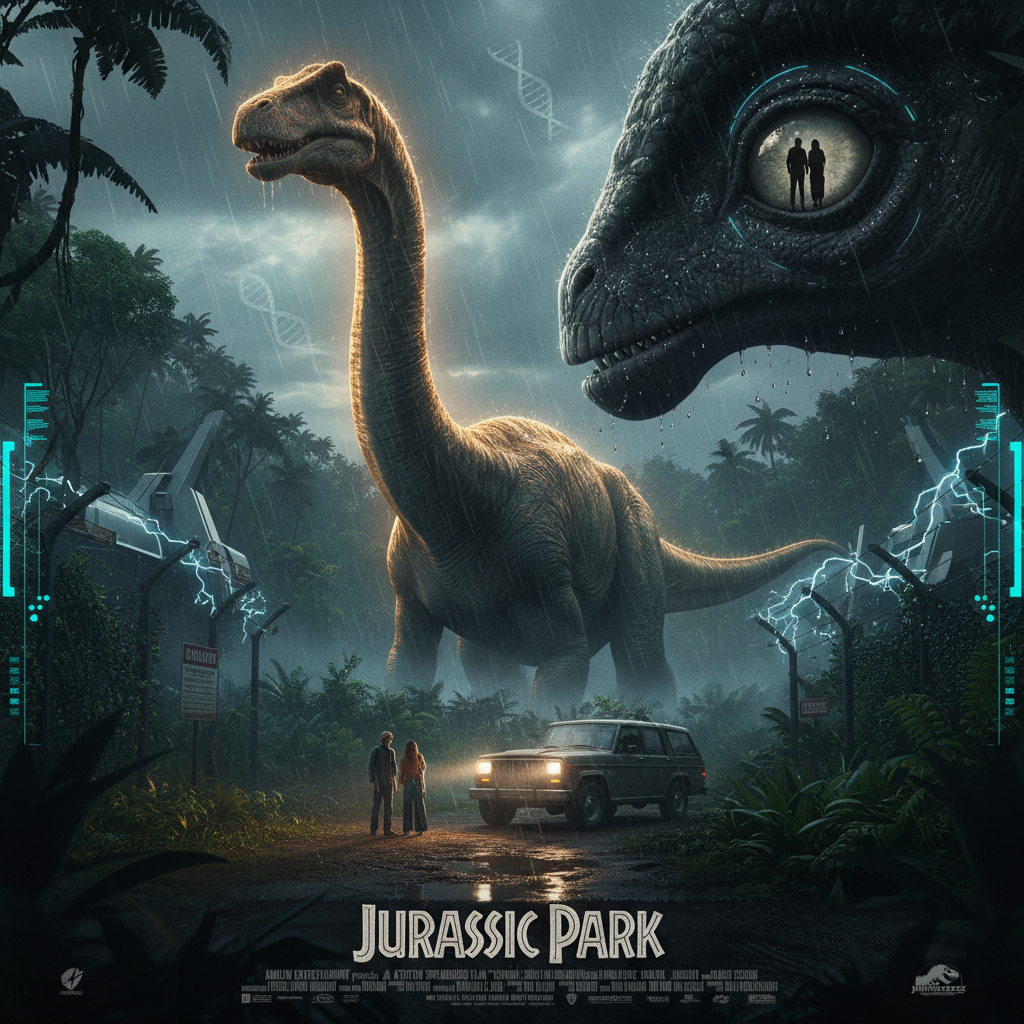

In [39]:
# Task 8c: Display the saved image (5 pts)
from IPython.display import Image, display
from pathlib import Path

output_path = Path(f"temp/poster_{movies[0].title}.png")
display(Image(filename=str(output_path)))

---

## Task 9: Submit via Pull Request (15 points)

Now let's practice a real-world development workflow! Instead of pushing directly to `main`, you'll create a **branch**, open a **Pull Request (PR)**, and **merge** it.

This is how professional developers submit code for review. Your TA will check your merged PR to verify your submission.

### 9a. Create a new branch (5 pts)

Run this command in your terminal to create and switch to a new branch:

In [1]:
# Task 9a: Create a new branch (5 pts)
# Run this in your terminal (not in this notebook!)

!git checkout -b homework-2

fatal: a branch named 'homework-2' already exists


### 9b. Commit your work (5 pts)

Stage all your changes and create a commit:

In [2]:
# Task 9b: Commit your work (5 pts)

!git add .
!git commit -m "Complete homework 2: Movie Poster Generator"

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [ ]:
# Task 9c: Push your branch (5 pts)
# It is not working in code because I made it require authentication because i was having problems having 2 different github accounts
!git push -u origin homework-2

bash: line 1: /dev/tty: No such device or address
error: failed to execute prompt script (exit code 1)
fatal: could not read Username for 'https://github.com': No such file or directory


### 9d. Create and Merge the Pull Request

Now go to your repository on GitHub (https://github.com/YOUR-USERNAME/ai-engineering-fordham):

1. You should see a banner saying **"homework-2 had recent pushes"** - click **"Compare & pull request"**
2. Give your PR a title: `"Homework 2: Movie Poster Generator"`
3. Click **"Create pull request"**
4. Review your changes in the PR
5. Click **"Merge pull request"** then **"Confirm merge"**

**Your PR should now show as "Merged"** - this is what the TA will check!

Run the cell below to verify your branch was merged:

In [ ]:
# Verify your PR was merged (run after merging on GitHub)
!git checkout main
!git pull
!git log --oneline -3

Your branch is up to date with 'origin/main'.


Switched to branch 'main'


Updating b745dee..b1bf09e
Fast-forward
 homework-1.ipynb              |   22 +-
 homework-2.ipynb              | 1541 +++++++++++++++++++++++++++++++
 pyproject.toml                |   20 +-
 temp/poster_Jurassic Park.png |  Bin 0 -> 1863231 bytes
 temp_League of Legends        |    0
 temp_The Glass Compass.png    |  Bin 0 -> 2088212 bytes
 uv.lock                       | 2009 ++++++++++++++++++++++++++++++++++++++++-
 7 files changed, 3558 insertions(+), 34 deletions(-)
 create mode 100644 homework-2.ipynb
 create mode 100644 temp/poster_Jurassic Park.png
 create mode 100644 temp_League of Legends
 create mode 100644 temp_The Glass Compass.png


From https://github.com/Samic34/ai-engineering-fordham
   b745dee..b1bf09e  main       -> origin/main


b1bf09e Merge pull request #1 from Samic34/homework-2
6ec1691 Complete homework 2: Movie Poster Generator
b745dee Complete homework 1


: 

---

## BONUS: Full Pipeline (10 bonus points)

Put everything together! Create a complete pipeline that takes a movie description and returns both the structured data AND a generated poster.

**Challenge:** Write your own original movie description and generate a poster for it!

In [40]:
# BONUS: Create a complete pipeline (10 bonus pts)
def generate_poster_image(prompt: str, movie: Movie):
    # Make sure to create temp directory
    os.makedirs("temp", exist_ok=True)

    # Create client
    google_client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))

    # Generate an image using Nano Banana (Gemini's native image generation)
    response = google_client.models.generate_content(
        model="gemini-2.5-flash-image",  # Nano Banana model
        contents=[prompt],
    )

    # Find and save the image from the response
    output_path = Path(f"temp_{movie.title}.png")
    output_path.parent.mkdir(exist_ok=True)

    for part in response.parts:
        if part.inline_data is not None:
            image = part.as_image()
            image.save(output_path)
            print(f"Image saved to {output_path}")
            break

    # Return as string to avoid issues with Path object in await
    return str(output_path)

async def movie_to_poster(description: str) -> tuple[Movie, str]:
    """
    Complete pipeline: description -> structured data -> poster

    Args:
        description: A text description of a movie

    Returns:
        Tuple of (Movie object, path to saved poster image)
    """
    # 1. Extract structured data from description using LiteLLM
    response = await litellm.acompletion(
        model="gpt-5-mini",
        messages=[
            {
                "role": "user",
                "content": f"Extract structured movie information (title, genre, director, main_cast, plot, setting, visual_style, mood) from this movie description:\n\n{description}"
            }
        ],
        response_format=Movie  # Expecting structure matching the Movie Pydantic schema
    )
    # 2. Convert extraction to Movie object
    movie = Movie.model_validate_json(response.choices[0].message.content)

    # 3. Generate a poster prompt from the extracted structure (e.g., summarize for poster)
    poster_prompt = f"Create a movie poster in the style of {movie.visual_style}, mood: {movie.mood}, genre: {movie.genre}. Title: {movie.title}."
    
    # 4. Generate poster image (assume generate_poster_image returns image path)
    poster_path = await asyncio.to_thread(generate_poster_image, poster_prompt, movie)

    return movie, poster_path

Image saved to temp_League of Legends: Blades of Harmony.png
Generated poster for: League of Legends: Blades of Harmony
{
  "title": "League of Legends: Blades of Harmony",
  "genre": "action",
  "year": 2026,
  "main_characters": [
    "Irelia",
    "Karma",
    "Kennen",
    "Zed",
    "Ahri"
  ],
  "mood": "Meditative yet suspenseful; themes of resilience, unity, and self-discovery set against the haunting beauty and peril of Ionia.",
  "visual_style": "Ethereal blooms, flowing silks, and dreamlike natural scenery; a blend of traditional East Asian art, magical realism, and kinetic martial arts action, suffused with luminous spirit energy.",
  "tagline": "When the Spirit Blossom rots, a blade-dancer must unite a fractured Ionia to restore harmony."
}


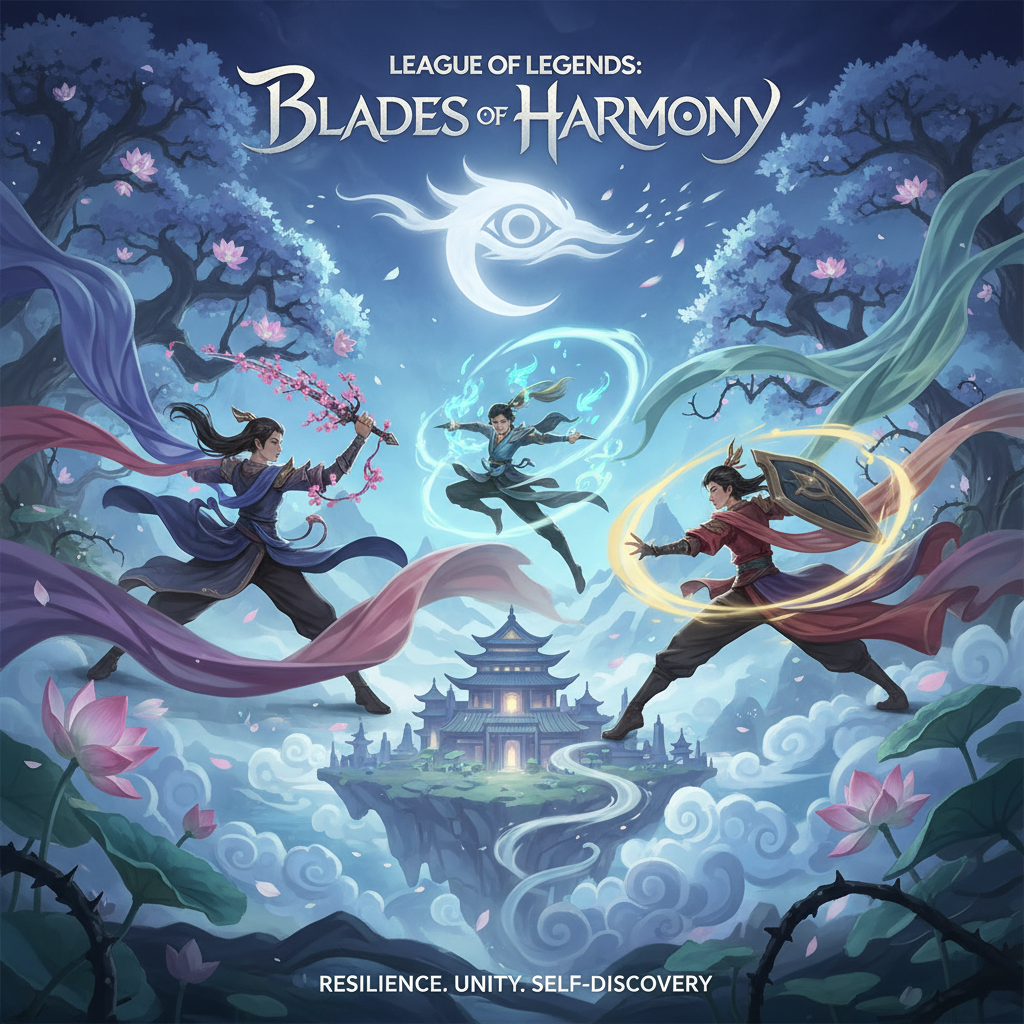

In [41]:
# Test with YOUR OWN original movie idea!

my_movie_description = """
Title: League of Legends: Blades of Harmony

Plot: In the tranquil yet war-scarred lands of Ionia, peace teeters on a knife’s edge. When a mysterious darkness seeps from the Spirit Blossom groves, corrupting nature and spirit alike, Irelia—the Blade Dancer—must rally her fractured homeland. Torn between honoring ancient Ionian traditions and forging a new path, Irelia sets out with a band of unlikely allies to uncover the true source of the corruption. Their journey takes them from the serene Placidium to the haunting ruins of Navori, testing their resolve, their unity, and the meaning of harmony.

Characters:
- Irelia, a master of levitating blades and reluctant leader yearning to heal her people
- Karma, the wise spiritual guide burdened by countless lifetimes
- Kennen, the energetic yordle lightning ninja who guards Ionia’s secrets
- Zed, a shadowy outcast whose motives blur the line between vengeance and justice
- Ahri, a fox spirit and empath torn between the mortal and spirit realms

Setting: The mystical, lush landscapes of Ionia—ancient forests, tranquil villages, floating monasteries, and vibrant spirit sanctuaries—beset by eerie corruption and spectral disturbances.

Visual Style: Ethereal blooms, flowing silks, and dreamlike natural scenery; a blend of traditional East Asian art, magical realism, and kinetic martial arts action, suffused with luminous spirit energy.

Mood: Meditative yet suspenseful; themes of resilience, unity, and self-discovery set against the haunting beauty and peril of Ionia.
"""

# Uncomment to run:
movie, poster_path = await movie_to_poster(my_movie_description)
print(f"Generated poster for: {movie.title}")
print(movie.model_dump_json(indent=2))
display(Image(poster_path))

---

## Submission Checklist

Before submitting, make sure:

- [ ] All code cells run without errors
- [ ] Your `Movie` schema includes all required fields with proper validation
- [ ] `extract_movie()` returns a valid `Movie` object
- [ ] Async processing works and shows timing
- [ ] Temperature comparison shows deterministic vs random outputs
- [ ] Logprobs visualization works and displays token probabilities
- [ ] Reasoning model comparison shows differences between o3-mini and gpt-5-mini
- [ ] You generated and displayed at least one movie poster
- [ ] Created branch `homework-2` and pushed to GitHub
- [ ] Opened a Pull Request from `homework-2` to `main`
- [ ] **Merged the PR** (it should show as "Merged" on GitHub)
- [ ] Submitted notebook on Blackboard

**Submission:**
1. Complete all tasks in this notebook
2. Create a PR and **merge it** on GitHub
3. Submit your notebook (`.ipynb` file) on **Blackboard**

**The TA will verify your submission by checking the merged PR on your GitHub repo.**

---

**Great work!** You've built a complete AI-powered application, explored LLM parameters and reasoning, and learned a professional Git workflow!